In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")

#此处特征的处理根据step1的数据分析来做。
all_df = pd.concat((train_df.loc[:,'MSSubClass':'SaleCondition'], test_df.loc[:,'MSSubClass':'SaleCondition']), axis=0,ignore_index=True)
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)
quantitative = [f for f in all_df.columns if all_df.dtypes[f] != 'object']
qualitative = [f for f in all_df.columns if all_df.dtypes[f] == 'object']

In [8]:
#缺失值处理
#对于缺失数据，我们直接将列删除
missing = all_df.isnull().sum()
missing.sort_values(inplace=True,ascending=False)
missing = missing[missing > 0]

#dealing with missing data
all_df = all_df.drop(missing[missing>1].index,1)
# 对于missing 1 的我们到时候以平均数填充
all_df.isnull().sum()[all_df.isnull().sum()>0]

Exterior1st    1
Exterior2nd    1
BsmtFinSF1     1
BsmtFinSF2     1
BsmtUnfSF      1
TotalBsmtSF    1
Electrical     1
KitchenQual    1
GarageCars     1
GarageArea     1
SaleType       1
dtype: int64

In [9]:
#处理log项
#GrLivArea、1stFlrSF、2ndFlrSF、TotalBsmtSF、LotArea、KitchenAbvGr、GarageArea 以上特征我们进行logp处理
logfeatures = ['GrLivArea','1stFlrSF','2ndFlrSF','TotalBsmtSF','LotArea','KitchenAbvGr','GarageArea']

for logfeature in logfeatures:
    all_df[logfeature] = np.log1p(all_df[logfeature].values)

In [11]:
#处理Boolean变量

all_df['HasBasement'] = all_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_df['HasGarage'] = all_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_df['Has2ndFloor'] = all_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_df['HasWoodDeck'] = all_df['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
all_df['HasPorch'] = all_df['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
all_df['HasPool'] = all_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_df['IsNew'] = all_df['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

quantitative = [f for f in all_df.columns if all_df.dtypes[f] != 'object']
qualitative = [f for f in all_df.columns if all_df.dtypes[f] == 'object']

In [20]:
#对于定性变量的encode
all_dummy_df = pd.get_dummies(all_df)

In [25]:
#对于数值变量进行标准化
all_dummy_df.isnull().sum().sum()

6

In [29]:
mean_cols = all_dummy_df.mean()
all_dummy_df = all_dummy_df.fillna(mean_cols)

In [30]:
all_dummy_df.isnull().sum().sum()

0

In [41]:
X = all_dummy_df[quantitative]
std = StandardScaler()
s = std.fit_transform(X)

In [59]:
all_dummy_df[quantitative] = s
print(train_df.index) #0-1459
print(test_df.index) #1460-2918

RangeIndex(start=0, stop=1460, step=1)
RangeIndex(start=0, stop=1459, step=1)


1459

In [60]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[max(train_df.index)+1:]

In [69]:
y_train = np.log(train_df.SalePrice)

# 以下进行模型预测

In [66]:
#此处我们先运用多个模型进行预测，最后进行bagging操作

#岭回归
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score


In [71]:
y_train.values

array([12.24769432, 12.10901093, 12.31716669, ..., 12.49312952,
       11.86446223, 11.90158345])

In [82]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, dummy_train_df, y_train.values, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [83]:
alphas = np.logspace(-3, 2, 50)
cv_ridge = []
coefs = []
for alpha in alphas:
    model = Ridge(alpha = alpha)
    model.fit(dummy_train_df,y_train)
    cv_ridge.append(rmse_cv(model).mean())
    coefs.append(model.coef_)

Text(0,0.5,'rmse')

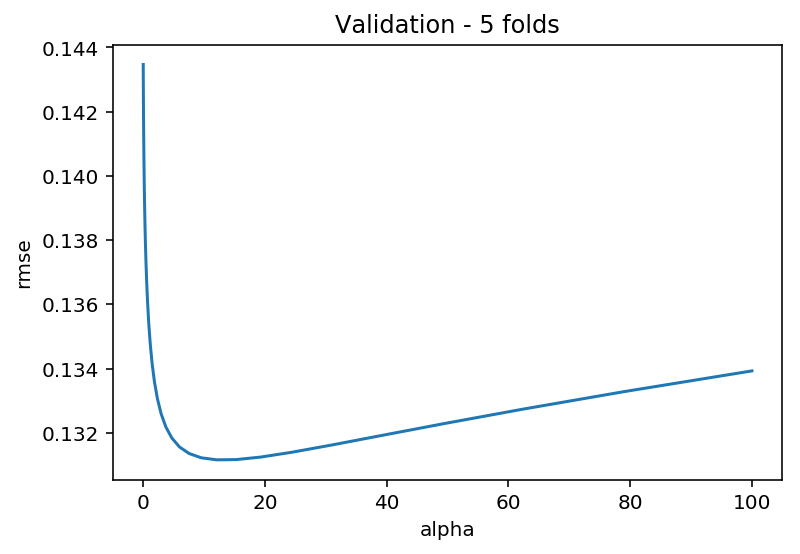

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - 5 folds")
plt.xlabel("alpha")
plt.ylabel("rmse")
# plt.plot(alphas, cv_ridge)
# plt.title("Alpha vs CV Error")

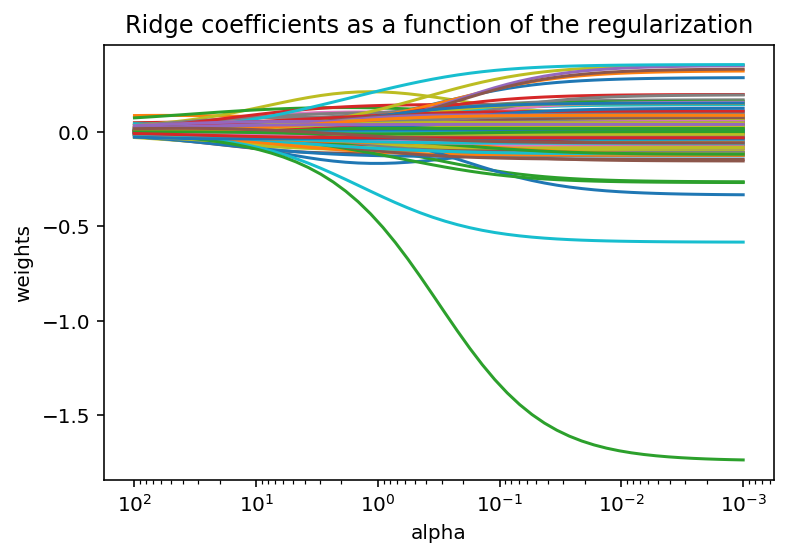

In [104]:
# 岭迹图
# matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
ax = plt.gca()

# ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [105]:
#主要是现在feature太多了。岭迹图看不出什么东西来
#Lasso能针对上面特征太多的问题，来选择一部分重要的特征
from sklearn.linear_model import Lasso,LassoCV

# alphas = np.logspace(-3, 2, 50)
# alphas = [1, 0.1, 0.001, 0.0005]
alphas = np.logspace(-4, -2, 100)
cv_lasso = []
coefs = []
for alpha in alphas:
    model = Lasso(alpha = alpha,max_iter=5000)
    model.fit(dummy_train_df,y_train)
    cv_lasso.append(rmse_cv(model).mean())
    coefs.append(model.coef_)


Text(0,0.5,'rmse')

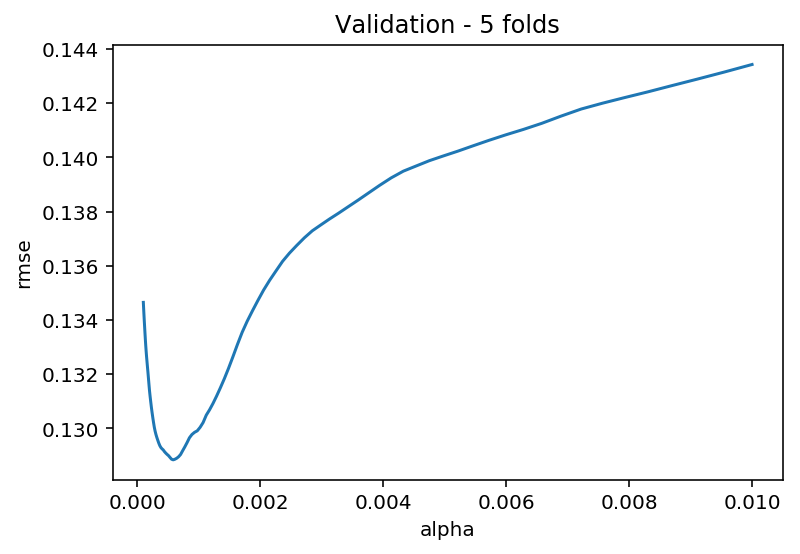

In [107]:
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - 5 folds")
plt.xlabel("alpha")
plt.ylabel("rmse")
# plt.plot(alphas, cv_ridge)
# plt.title("Alpha vs CV Error")

In [110]:
print(cv_lasso.min(), cv_lasso.argmin())

0.1288436807216547 0.0005857020818056667


In [111]:
model = Lasso(alpha = 0.00058,max_iter=5000)
model.fit(dummy_train_df,y_train)

Lasso(alpha=0.00058, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [112]:
coef = pd.Series(model.coef_, index = dummy_train_df.columns)

In [113]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 85 variables and eliminated the other 141 variables


In [114]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso Model')

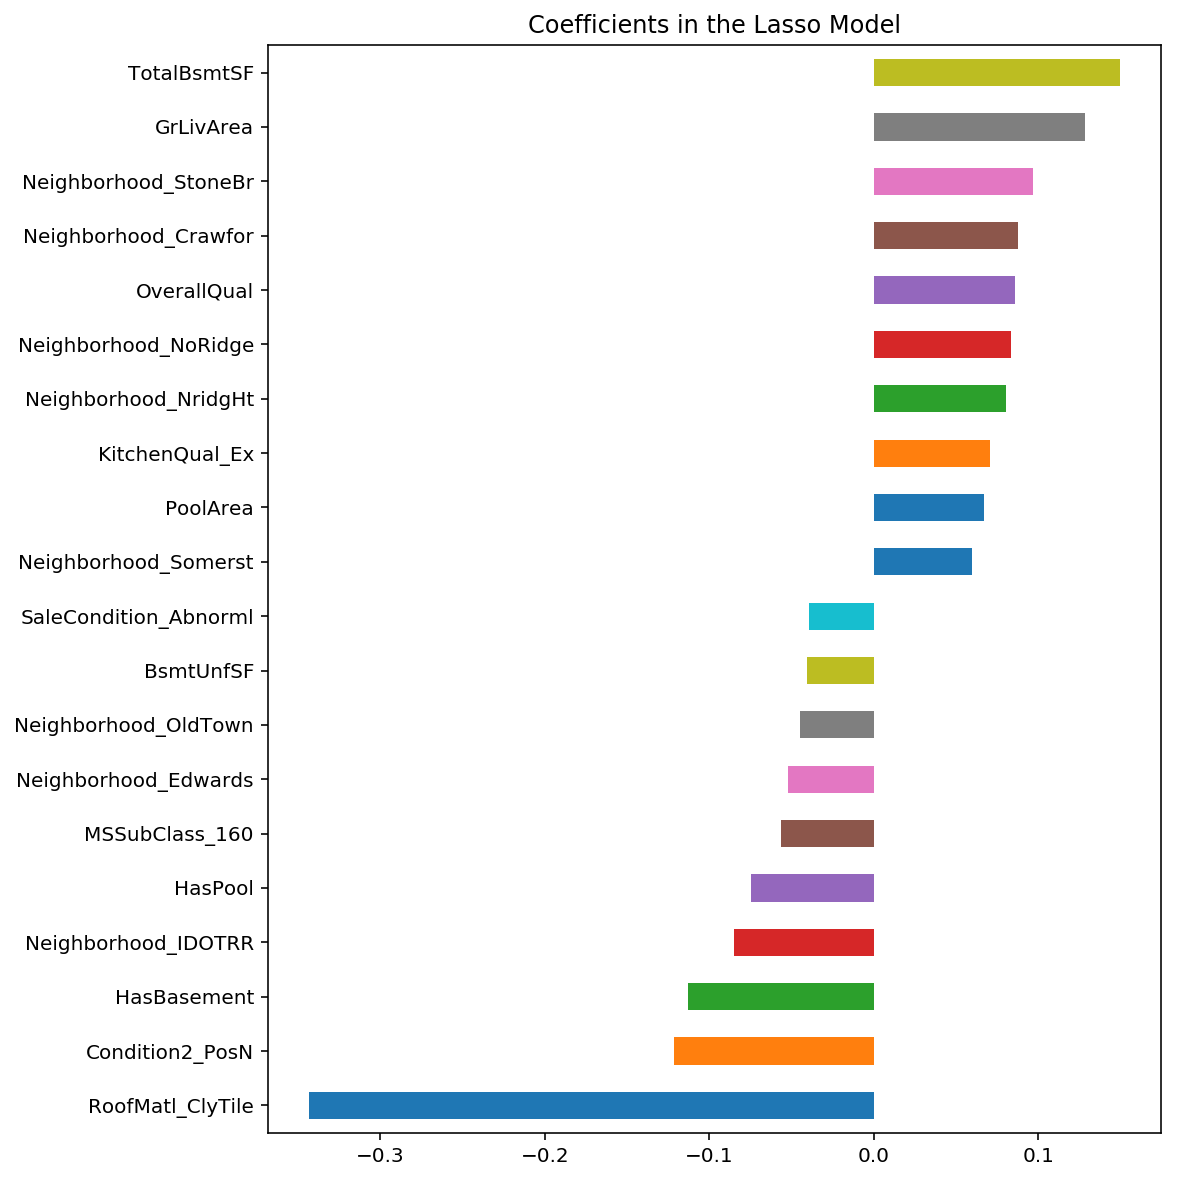

In [116]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [117]:
from sklearn.linear_model import ElasticNet,ElasticNetCV

In [118]:
elastic = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                                    alphas=[0.001, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], cv=5,max_iter=5000)

In [119]:
elastic.fit(dummy_train_df, y_train)

ElasticNetCV(alphas=[0.001, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],
       copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=5000,
       n_alphas=100, n_jobs=None, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [120]:
rmse_cv(elastic).mean()

0.12908591441325346

In [137]:
#进行预测
def predict(model,target="./results.csv"):
    answers = np.exp(model.predict(dummy_test_df))
    Id = np.array(test_df["Id"])
    results = pd.DataFrame(np.c_[Id,answers],columns=["Id","SalePrice"])
    results["Id"] = results["Id"].astype("int")
    results.to_csv(target,index=False)
predict(elastic) #模型结果排名1600

### 这种提取特征的方式，取得的排名结果不是很好，所以，此处可以考虑使用
### https://www.kaggle.com/opanichev/ensemble-of-4-models-with-cv-lb-0-11489 
### 这篇文章的方式来处理特征

In [64]:
dummy_train_df.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.103719,0.646183,-0.507284,1.046258,0.896833,0.580907,-0.29313,-0.934863,0.017265,-0.777287,...,0,0,0,1,0,0,0,0,1,0
1,0.146544,-0.063185,2.188279,0.154764,-0.395604,1.178112,-0.29313,-0.629896,0.347125,0.424865,...,0,0,0,1,0,0,0,0,1,0
2,0.457629,0.646183,-0.507284,0.980221,0.848965,0.097873,-0.29313,-0.288516,0.078525,-0.554028,...,0,0,0,1,0,0,0,0,1,0
3,0.136301,0.646183,-0.507284,-1.859351,-0.682812,-0.494941,-0.29313,-0.047275,-0.088270,-0.419015,...,0,0,0,1,1,0,0,0,0,0
4,0.922662,1.355551,-0.507284,0.947203,0.753229,0.468931,-0.29313,-0.161068,0.264438,0.123520,...,0,0,0,1,0,0,0,0,1,0


In [65]:
dummy_test_df.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,0.521437,-0.772552,0.391237,-0.340510,-1.113625,0.058352,0.558197,-0.661759,0.042686,-0.635877,...,0,0,0,1,0,0,0,0,1,0
1461,0.923625,-0.063185,0.391237,-0.439565,-1.257229,1.057354,-0.293130,-0.352241,0.391090,0.585094,...,0,0,0,1,0,0,0,0,1,0
1462,0.862607,-0.772552,-0.507284,0.848148,0.657493,0.767534,-0.293130,-0.964449,0.085882,-0.527218,...,0,0,0,1,0,0,0,0,1,0
1463,0.222291,-0.063185,0.391237,0.881166,0.657493,0.352564,-0.293130,-0.538862,0.084048,-0.533898,...,0,0,0,1,0,0,0,0,1,0
1464,-1.130892,1.355551,-0.507284,0.683057,0.370284,-0.391747,-0.293130,1.038314,0.359161,0.468732,...,0,0,0,1,0,0,0,0,1,0


In [63]:
all_dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 226 entries, LotArea to SaleCondition_Partial
dtypes: float64(37), uint8(189)
memory usage: 1.4 MB
